In [1]:
import sys
sys.path.insert(1, '../')


In [61]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciii_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [68]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

estimators = [('Scaler', StandardScaler()), 
              ('Neural_Network', MLPClassifier(
                  hidden_layer_sizes=(100),
                  random_state=seed, 
                  activation='logistic', 
                  solver='sgd', 
                  max_iter=1000))]
pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, pipe.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8095044991980281
Average Precision: 0.7386963052733777
Accuracy: 0.7556693489392831


| Step 1  ==> Calibrating model


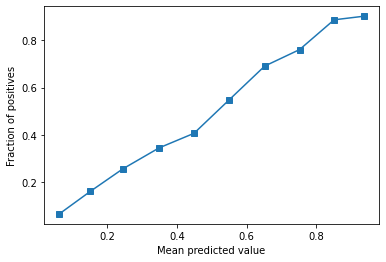

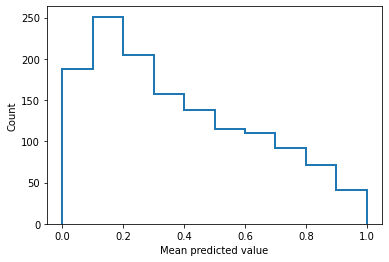

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


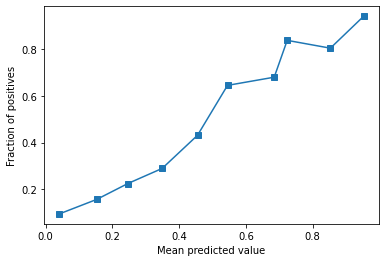

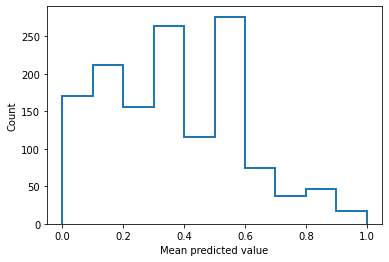

ROC AUC: 0.8095044991980281
Average Precision: 0.7386963052733777
Accuracy: 0.7556693489392831
ROC AUC: 0.7846626281116055
Average Precision: 0.6861414984866986
Accuracy: 0.745427944403804

| Step 2 ==> Calculate SHAP values


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Kernel Explainer Iteration 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Kernel Explainer Iteration 1


  0%|          | 0/1000 [00:00<?, ?it/s]


| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 8.0

Probability threshold: 0.5
Score threshold: 10.0

Probability threshold: 0.9
Score threshold: 11.0



In [70]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

explainer = medical_explainer.explainer(
    pipe, X_train[:1000], y_train[:1000], X_test, y_test)

explainer.fit(10, shap_method='kernel', method='novel', n_splits=2)

In [71]:
explainer.variables

array(['inotropes', 'LOS', 'Age', 'Phosphate', 'RDW', 'Monos', 'AF',
       'Haptoglobin', 'Albumin', 'Nucleated Red Cells'], dtype=object)

In [72]:
explainer.score_array_list

[array([-1.,  1.]),
 array([-1.]),
 array([-1.]),
 array([-1., -0.]),
 array([-1.,  0.]),
 array([-1.,  2.]),
 array([-1.]),
 array([-1.]),
 array([-1.]),
 array([-1.,  3.])]

In [73]:
explainer.breakpoints_list

[[0.0, 2.1316729183945586, 3.0],
 [-0.0645833333333333, 145.85763888888889],
 [18.2943189596167, 90.0],
 [0.4, 11.312186332709434, 11.5],
 [12.0, 23.42602796455752, 30.5],
 [0.0, 33.52874799899694, 68.0],
 [-0.5697068810513599, 1.0],
 [-68.92418285305257, 653.0],
 [1.0, 5.1],
 [1.0, 50.35793569177678, 150.0]]

In [74]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [75]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.5142531240654988
Average Precision: 0.39400458463849714
Accuracy: 0.6174103877103145
[[844   0]
 [523   0]]


In [76]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [77]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.5153605743849645, 0.511107046958708, 0.519614101811221)
(0.4019805269766309, 0.39816624689462077, 0.405794807058641)
(0.615, 0.615, 0.615)
